# Прогнозирование оттока клиентов оператора связи

## 1. Описание проекта

### 1.1. Цель проекта

Построить модель для прогнозирования оттока клиентов оператора связи «Ниединогоразрыва.ком». Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. 

### 1.2. Описание услуг

Оператор предоставляет два основных типа услуг.
* Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
* Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны следующие услуги.
* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity).
* Выделенная линия технической поддержки (TechSupport).
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup).
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### 1.3. Описание данных

Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Данные состоят из файлов, полученных из разных источников:
* contract_new.csv — информация о договоре;
* personal_new.csv — персональные данные клиента;
* internet_new.csv — информация об интернет-услугах;
* phone_new.csv — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.

### 1.4. План работы

1. Ознакомиться с данными из всех представленных выше файлов.
2. Объединить данные из всех файлов.
3. Провести исследовательский анализ данных.
4. Выполнить предобработку данных.
5. Подготовить признаки перед обучением моделей.
6. Выбрать несколько моделей и проверить их работу с помощью кросс-валидации. 
7. По результатам кросс-валидации выбрать лучшую модель и протестировать её.

В качестве основной метрики качества в данном проекте будет использоваться метрика *AUC-ROC*, её значение на тестовой выборке должно быть не менее 0.85. В качестве дополнительной метрики качества будет использоваться метрика *accuracy*.

## 2. Знакомство с данными

Импортируем необходимые библиотеки и считаем данные из файлов.

In [1]:
import re
import phik
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

RANDOM_STATE = 170723

In [2]:
df_contract = pd.read_csv('contract_new.csv')
df_personal = pd.read_csv('personal_new.csv')
df_internet = pd.read_csv('internet_new.csv')
df_phone = pd.read_csv('phone_new.csv') 

Ознакомимся с данными из каждого файла. Для этого выведем случайные 5 строк каждого датафрейма и вызовем для них метод `info`.

In [3]:
df_contract.sample(n=5, random_state=RANDOM_STATE)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
5010,3654-ARMGP,2015-01-01,No,Two year,No,Credit card (automatic),88.65,5678.03
1283,4389-UEFCZ,2014-02-01,No,Two year,Yes,Electronic check,105.50,7596.0
2287,5440-FLBQG,2014-02-01,2016-06-01,Two year,Yes,Bank transfer (automatic),108.40,3035.2
2820,3251-YMVWZ,2015-09-01,No,One year,No,Bank transfer (automatic),24.05,1389.37
4071,6537-QLGEX,2018-10-01,No,Month-to-month,Yes,Electronic check,38.90,622.4


In [4]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
df_personal.sample(n=5, random_state=RANDOM_STATE)

,customerID,gender,SeniorCitizen,Partner,Dependents
5010,3654-ARMGP,Female,0,No,No
1283,4389-UEFCZ,Female,0,Yes,No
2287,5440-FLBQG,Male,1,Yes,No
2820,3251-YMVWZ,Male,0,No,No
4071,6537-QLGEX,Female,0,No,No


In [6]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [7]:
df_internet.sample(n=5, random_state=RANDOM_STATE)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5347,8930-XOTDP,DSL,No,No,No,No,Yes,No
673,0727-BMPLR,Fiber optic,No,No,Yes,No,Yes,Yes
4260,5959-BELXA,Fiber optic,No,No,No,No,Yes,Yes
1190,4472-VESGY,Fiber optic,Yes,Yes,Yes,No,No,Yes
4954,9661-MHUMO,DSL,No,No,No,Yes,No,No


In [8]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
df_phone.sample(n=5, random_state=RANDOM_STATE)

,customerID,MultipleLines
4802,2144-BFDSO,Yes
2398,3130-ICDUP,Yes
8,7469-LKBCI,No
6007,4816-OKWNX,No
3013,2195-VVRJF,No


In [10]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Выводы.**
* Во всех датафреймах есть столбец `customerID`, по которому в дальнейшем можно все эти датафреймы объединить в один.
* Количество строк в датафреймах разное. Можно предположить, что в таблицах `df_contract` (информация о договорах) и `df_personal` (персональные данные клиентов) содержатся данные обо всех клиентах компании, поскольку, во-первых, договор обычно заключается со всеми клиентами, а для заключения договора необходимы персональные данные, а, во-вторых, количество строк в этих датафреймах одинаковое и больше, чем в двух других таблицах. А в `df_internet` и `df_phone` содержатся данные только о клиентах, которые пользуются интернет- или телефонными услугами компании. Если моё предположение верно, то при объединении таблиц типом объединения `full outer` по столбцу `customerID` в итоговом датафрейме будет 7043 строки, а в столбцах из датафреймов `df_internet` и `df_phone` появятся пропуски у тех клиентов, которые не пользуются интернет- или телефонными услугами компании.
* Во всех датафреймах нет пропусков, однако, может быть такое, что в некоторых столбцах вместо пропусков просто стоят заглушки. В выведенных на экран строках таких заглушек не видно, но при более подробном рассмотрении и предобработке данных это может всплыть.
* Во столбцах `BeginDate`, `TotalCharges` тип данных не соответствует содержимому, то есть во время предобработки данных необходимо будет изменять типы данных таких столбцов.
* В данных преобладают категориальные столбцы, а поскольку не все модели умеют напрямую с ними работать, то их нужно будет кодировать.
* Названия столбцов записаны не в змеином регистре, это тоже надо будет исправить.
* Целевой признак дан не в явном виде, но его можно выделить из столбца `EndDate` датафрейма `df_contract`: если значение этого столбца равно "No", значит клиент ещё пользуется услугами компании, если же в нём записана дата, значит в эту дату клиент прервал свой договор с компанией. 

## 2. Исследовательский анализ данных и предобработка данных

Для начала объединим все датафреймы в один по признаку `customerID`, используя тип объединения `full outer`, чтобы в итоговый датафрейм вошли данные обо всех пользователях из всех таблиц.

In [11]:
df = pd.merge(df_contract, pd.merge(df_personal, pd.merge(df_internet, df_phone, how='outer', on='customerID'),
                                             how='outer', on='customerID'), how='outer', on='customerID')

Сразу проверим, что в данных отсутствуют дубликаты. Искать дубликаты будем только в столбце `customerID`, поскольку никакие другие столбцы или их сочетания не будут являться уникальными для каждого из клиентов

In [12]:
print('Количество дубликатов:', df.duplicated(subset=['customerID']).sum())

Количество дубликатов: 0


Удостоверились, что в данных нет дубликатов. 


Далее приведём названия всех столбцов к змеиному регистру.

In [13]:
new_column_names = []
for column in df.columns:
    new_column_names.append('_'.join(re.findall('\w\w[^A-Z]*', column)).lower())
df.columns = new_column_names

Теперь подробнее изучим данные. Для этого выведем 5 случайных строк, получившегося датафрейма, вызовем для него метод `info`.

In [14]:
df.sample(n=5, random_state=RANDOM_STATE)

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
5010,3654-ARMGP,2015-01-01,No,Two year,No,Credit card (automatic),88.65,5678.03,Female,0,No,No,DSL,No,Yes,Yes,Yes,Yes,Yes,Yes
1283,4389-UEFCZ,2014-02-01,No,Two year,Yes,Electronic check,105.50,7596.0,Female,0,Yes,No,Fiber optic,Yes,No,Yes,No,Yes,Yes,Yes
2287,5440-FLBQG,2014-02-01,2016-06-01,Two year,Yes,Bank transfer (automatic),108.40,3035.2,Male,1,Yes,No,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes
2820,3251-YMVWZ,2015-09-01,No,One year,No,Bank transfer (automatic),24.05,1389.37,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes
4071,6537-QLGEX,2018-10-01,No,Month-to-month,Yes,Electronic check,38.90,622.4,Female,0,No,No,DSL,Yes,No,No,No,Yes,No,NaN


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  internet_service   5517 non-null   object 
 13  online_security    5517 non-null   object 
 14  online_backup      5517 non-null   object 
 15  device_protection  5517 non-null   object 
 16  tech_support       5517 

Видим, что, как и ожидалось, итоговое количество строк в датафрейме равно 7043, и в данных появились пропуски. Визуализируем объём пропусков с помощью графика, для этого напишем соответствующую функцию `pass_value_barh`.

In [16]:
# Функция, которая визуализирует объём пропусков в данных
def pass_value_barh(df):
    if df.isna().sum().sum() > 0:
        ax = (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(12, 5), legend=False, fontsize=12)
        )
        ax.set_title('Объём пропусков в данных \n', fontsize=16, color='SteelBlue')
        ax.set_ylabel('Названия столбцов', fontsize=13)
        ax.set_xlabel('% пропусков', fontsize=13)
    else:
        print('В датафрейме нет пропусков.')

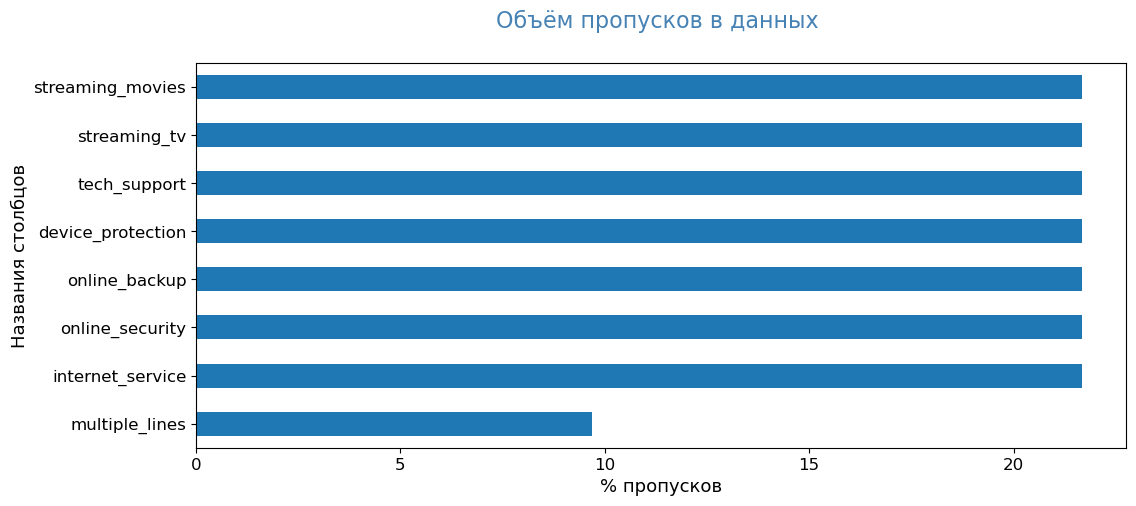

In [17]:
pass_value_barh(df)

В 8 столбцах появились пропуски, они соответствуют тем клиентам компании, которые не пользуются либо интернет- (столбцы, в которых более 20% пропусков), либо телефонными (столбец, в котором около 10% пропусков) услугами. Это два основных типа услуг компании, поэтому не должно быть таких клиентов, которые не пользовались бы ни тем, ни другим, иначе им бы просто не было смысла быть клиентами оператора связи. Сразу проверим это предположение. 

In [18]:
print('Число клиентов, которые не пользуются ни интернет-, ни телефонными услугами:',
      df[df['internet_service'].isna() & df['multiple_lines'].isna()].shape[0])

Число клиентов, которые не пользуются ни интернет-, ни телефонными услугами: 0


Видим, что действительно нет клиентов, которые бы не пользовались ни одной из основных услуг компании. 

Но прежде, чем заполнять пропуски в столбцах, подробнее изучим данные, построив гистограммы для числовых столбцов, cтолбчатые диаграммы для категориальных. Однако прежде, чем это сделать, изменим типы данных в тех столбцах, в которых содержание не соответствует заявленному типу данных: столбец `begin_date` приведём к типу `datetime`, а столбец `total_charges` - к типу `float`. Также изменим тип данных столбца `end_date`. Хотя его содержимое соответствует типу `object`, так как в нём присутствуют и даты, и буквенные значения "No", но с помощью этого столбца можно выделить ещё один важный признак для обучения моделей - длительность контракта. Для того чтобы это сделать, заменим все значения "No" в нём на дату "2020-02-01", на момент которой была актуальна информация о договорах клиентов с компанией, и затем изменим тип данных столбца `end_date` на `datetime`. Однако прежде выделим из этого столбца целевой признак `is_not_client`, где "1" значит, что человек больше не является клиентом компании, а "0" - что по-прежнему является.

In [19]:
df['is_not_client'] = df['end_date'].map(lambda x: 0 if x == 'No' else 1)

In [20]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')
df['total_charges'] = pd.to_numeric(df['total_charges'], downcast='float', errors='coerce')
df['end_date'] = df['end_date'].replace('No', '2020-02-01')
df['end_date'] = pd.to_datetime(df['end_date'], format='%Y-%m-%d')

Сразу проверим, что типы данных в этих столбцах были успешно изменены.

In [21]:
df[['begin_date', 'end_date', 'total_charges']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   begin_date     7043 non-null   datetime64[ns]
 1   end_date       7043 non-null   datetime64[ns]
 2   total_charges  7032 non-null   float32       
dtypes: datetime64[ns](2), float32(1)
memory usage: 192.6 KB


Теперь можно выделить признак "длительность контракта" (`duration_contract`). Признаки `end_date` и `begin_date` удалим, поскольку если их не удалить, то информация о длительности контракта будет храниться в явном и неявном видах, то есть информация будет дублироваться.

In [22]:
df['duration_contract'] = (df['end_date'] - df['begin_date']).dt.days

df = df.drop(['end_date', 'begin_date'], axis=1)

В процессе преобразования типа данных столбца `total_charges` было обнаружено, что в нём присутствуют пропущенные значения записанные как пустая строка. Чтобы исправить ошибку, возникшую, при изменении типа данных этого столбца и сделать пропуски более явными, установили `errors='coerce'` в функции `pd.to_numeric`. В результате работы этой функции всем значения, этого столбца, записанным как пустые строки, были присвоены значения `NaN`. Посмотрим, сколько пропусков и в каких строках образовалось.

In [23]:
df[df['total_charges'].isna()].reset_index(drop=True)

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,is_not_client,duration_contract
0,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0,0
1,3115-CZMZD,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
2,5709-LVOEQ,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
3,4367-NUYAO,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
4,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0,0
5,7644-OMVMY,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
6,3213-VVOLG,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0,0
7,2520-SGTTA,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
8,2923-ARZLG,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0,0
9,4075-WKNIU,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


В столбце `total_charges` появилось 11 пропусков. Они соответствуют тем клиентам, которые заключили договор с компанией в тот же день, когда эти данные последний раз были обновлены перед выгрузкой (значения столбцов `begin_date` и `end_date` равны), то есть эти клиенты ещё не успели оплатить услуги компании. Далее при работе с пропусками заполним пропуски в этом столбце нулями. 

Теперь построим гистограммы для числовых столбцов, а также диаграмму, показывающую зависимость между каждой парой числовых признаков и ядерную оценку плотностей этих признаков в разбивке по значениям целевого признака.

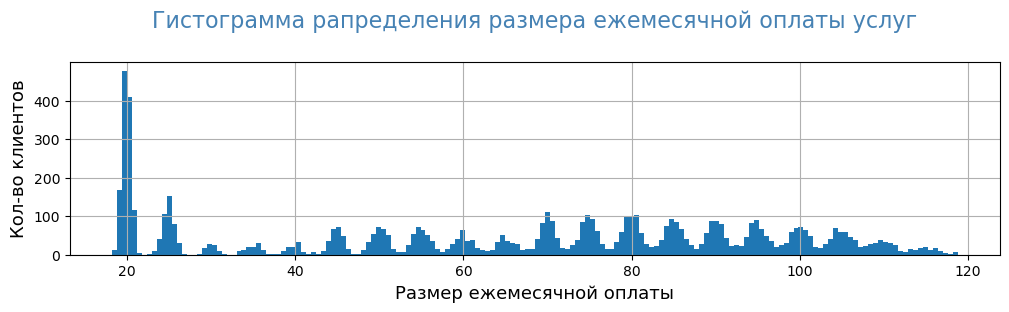

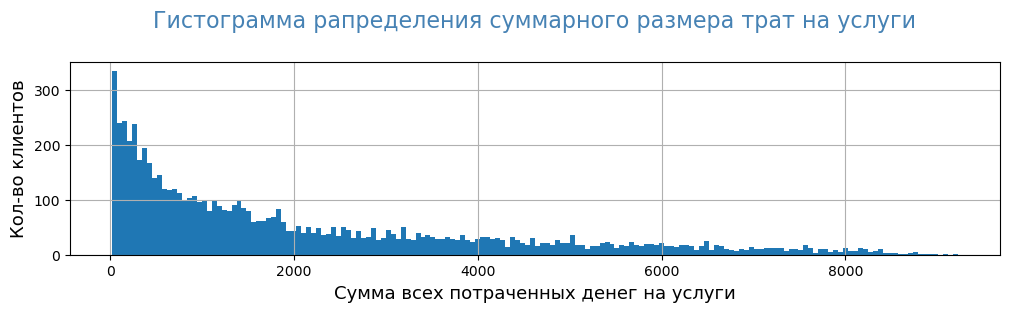

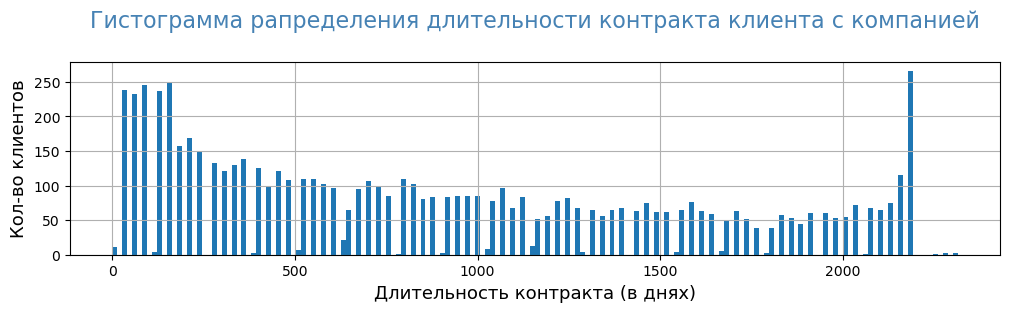

In [24]:
num_columns = ['monthly_charges', 'total_charges', 'duration_contract']
names_hist = ['размера ежемесячной оплаты услуг\n', 'суммарного размера трат на услуги\n', 
              'длительности контракта клиента с компанией\n']
xlabel_hist = ['Размер ежемесячной оплаты', 'Сумма всех потраченных денег на услуги', 'Длительность контракта (в днях)']

for col, name_hist, xlabel in zip(num_columns, names_hist, xlabel_hist):
    ax = df[col].hist(bins=170, figsize=(12, 2.5));
    ax.set_title('Гистограмма рапределения ' + name_hist, fontsize=16, color='SteelBlue')
    ax.set_ylabel('Кол-во клиентов', fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    plt.show()

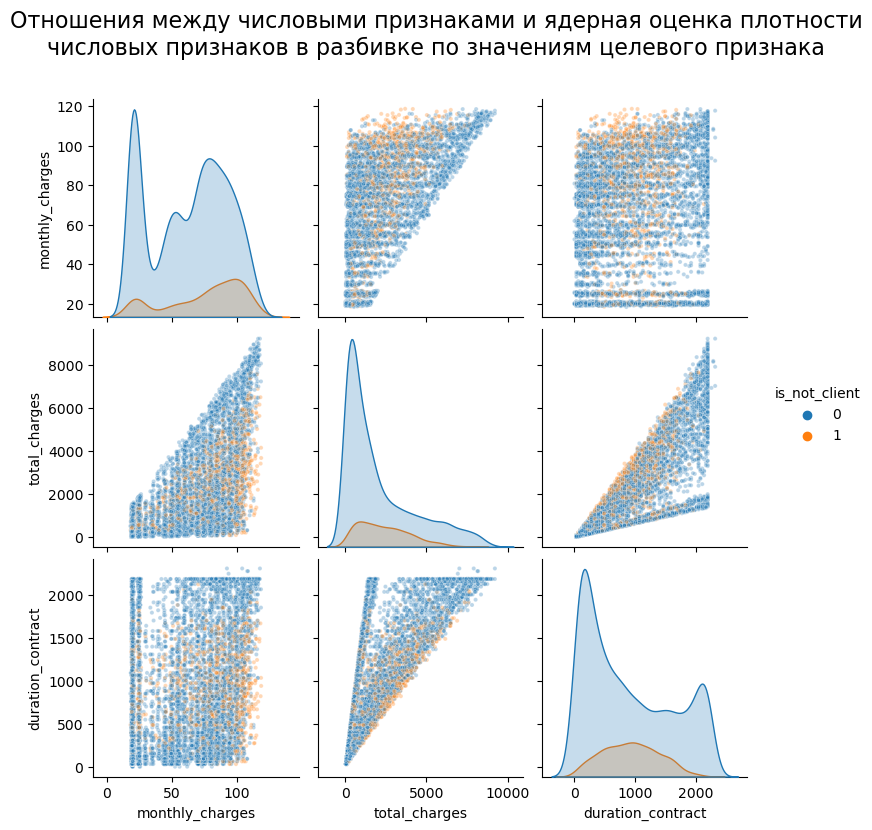

In [25]:
g = sns.pairplot(df[num_columns + ['is_not_client']], 
                 hue='is_not_client', plot_kws={'alpha':0.3}, markers='.')
g.fig.suptitle('Отношения между числовыми признаками и ядерная оценка плотности\nчисловых признаков ' + 
               'в разбивке по значениям целевого признака', y=1.1, fontsize=16);

**Выводы.**
* При ежемесячной оплате самой популярной ценой за услуги компании является цена в районе 20 денежных единиц (далее д.ед.); такая цена за месяц услуг примерно у 17% клиентов компании.
* На гистограмме размера ежемесячной платы наблюдаются небольшие столбики в районах значений цен кратных 5. Это, вероятно, связано с тем, что цены на товары и услуги в принципе часто округляют до каких-либо значений, например, до кратных 10, или заканчивающихся на 9 и т.п.
* Ежемесячных платежей размером примерно от 27 и до 42 д.ед значительно меньше, чем платежей меньшего и большего размера. Можно предположить, что это связано с наличием или отсутствием дополнительных услуг.
* Гистограмма `total_charges` выглядит ожидаемо: чем больше итоговая сумма трат, тем меньше таких клиентов у компании.
* Небольшие значение итоговой суммы, потраченной на услуги компании, вероятно, соответствуют людям, которые недавно стали клиентами компании. Соответственно, чем дольше человек является клиентом компании и чем большим количеством её услуг он пользуется, тем выше итоговая сумма его трат.
* После 200 дней на гистограмме столбца `duration_contract` наблюдается довольно резкое падение, примерно на 40%. С чем это связано точно сказать нельзя, но можно предположить, что, например, компания предоставляет клиентам пробный период, в течение которого клиенты получают какую-то скидку или бонус и который длится примерно 200 дней, после чего часть клиентов уходит.
* Всего несколько человек были клиентами компании более 2200 дней (около 6 лет). Можно предположить, что это были одни из самых первых клиентов компании, когда их приток был ещё небольшим.
* На гистограмме столбца `duration_contract` в районе 2150-2200 дней наблюдается резкий пик. Имеющихся данных недостаточно, чтобы точно сказать, с чем это связано, но можно предположить, что вскоре после открытия компанией была проведена какая-то маркетинговая акция, которая вызвала резкое увеличение числа клиентов.
* Признаки `monthly_charges` и `total_charges` а также `total_charges` и `duration_contract` явно коррелируют между собой, причём эта зависимость прямая. А вот  признаки `monthly_charges` и `duration_contract`, напротив, практически не зависят друг от друга.
* По графикам ядерной оценки плотностей видно, что клиенты, пользующиеся услугами компании примерно от 1 года и 4 месяцев и до 4 лет (500-1500 дней), более склонны к уходу. И напротив, те кто пользуются услугами меньше или дольше этого времени менее склонны к уходу, особенно это касается тех, кто пользуется услугами больше 2000 дней.
* Клиенты с большей ежемесячной оплатой более склонны к уходу.
* Явной зависимости между суммарным размером трат на услуги компании и уходом клиентов по диаграммам не видно.

Теперь построим столбчатые диаграммы для категориальных признаков.

Для удобства создадим список столбцов с категориальными данными, в него войдут все столбцы с типом данных `object`, кроме `customer_id` и единственный категориальный столбец с типом данных `int` - `senior_citizen`. 

In [26]:
cat_columns = df.select_dtypes(include=['object']).columns.to_list() + ['senior_citizen']
cat_columns.remove('customer_id')
cat_columns

['type',
 'paperless_billing',
 'payment_method',
 'gender',
 'partner',
 'dependents',
 'internet_service',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'multiple_lines',
 'senior_citizen']

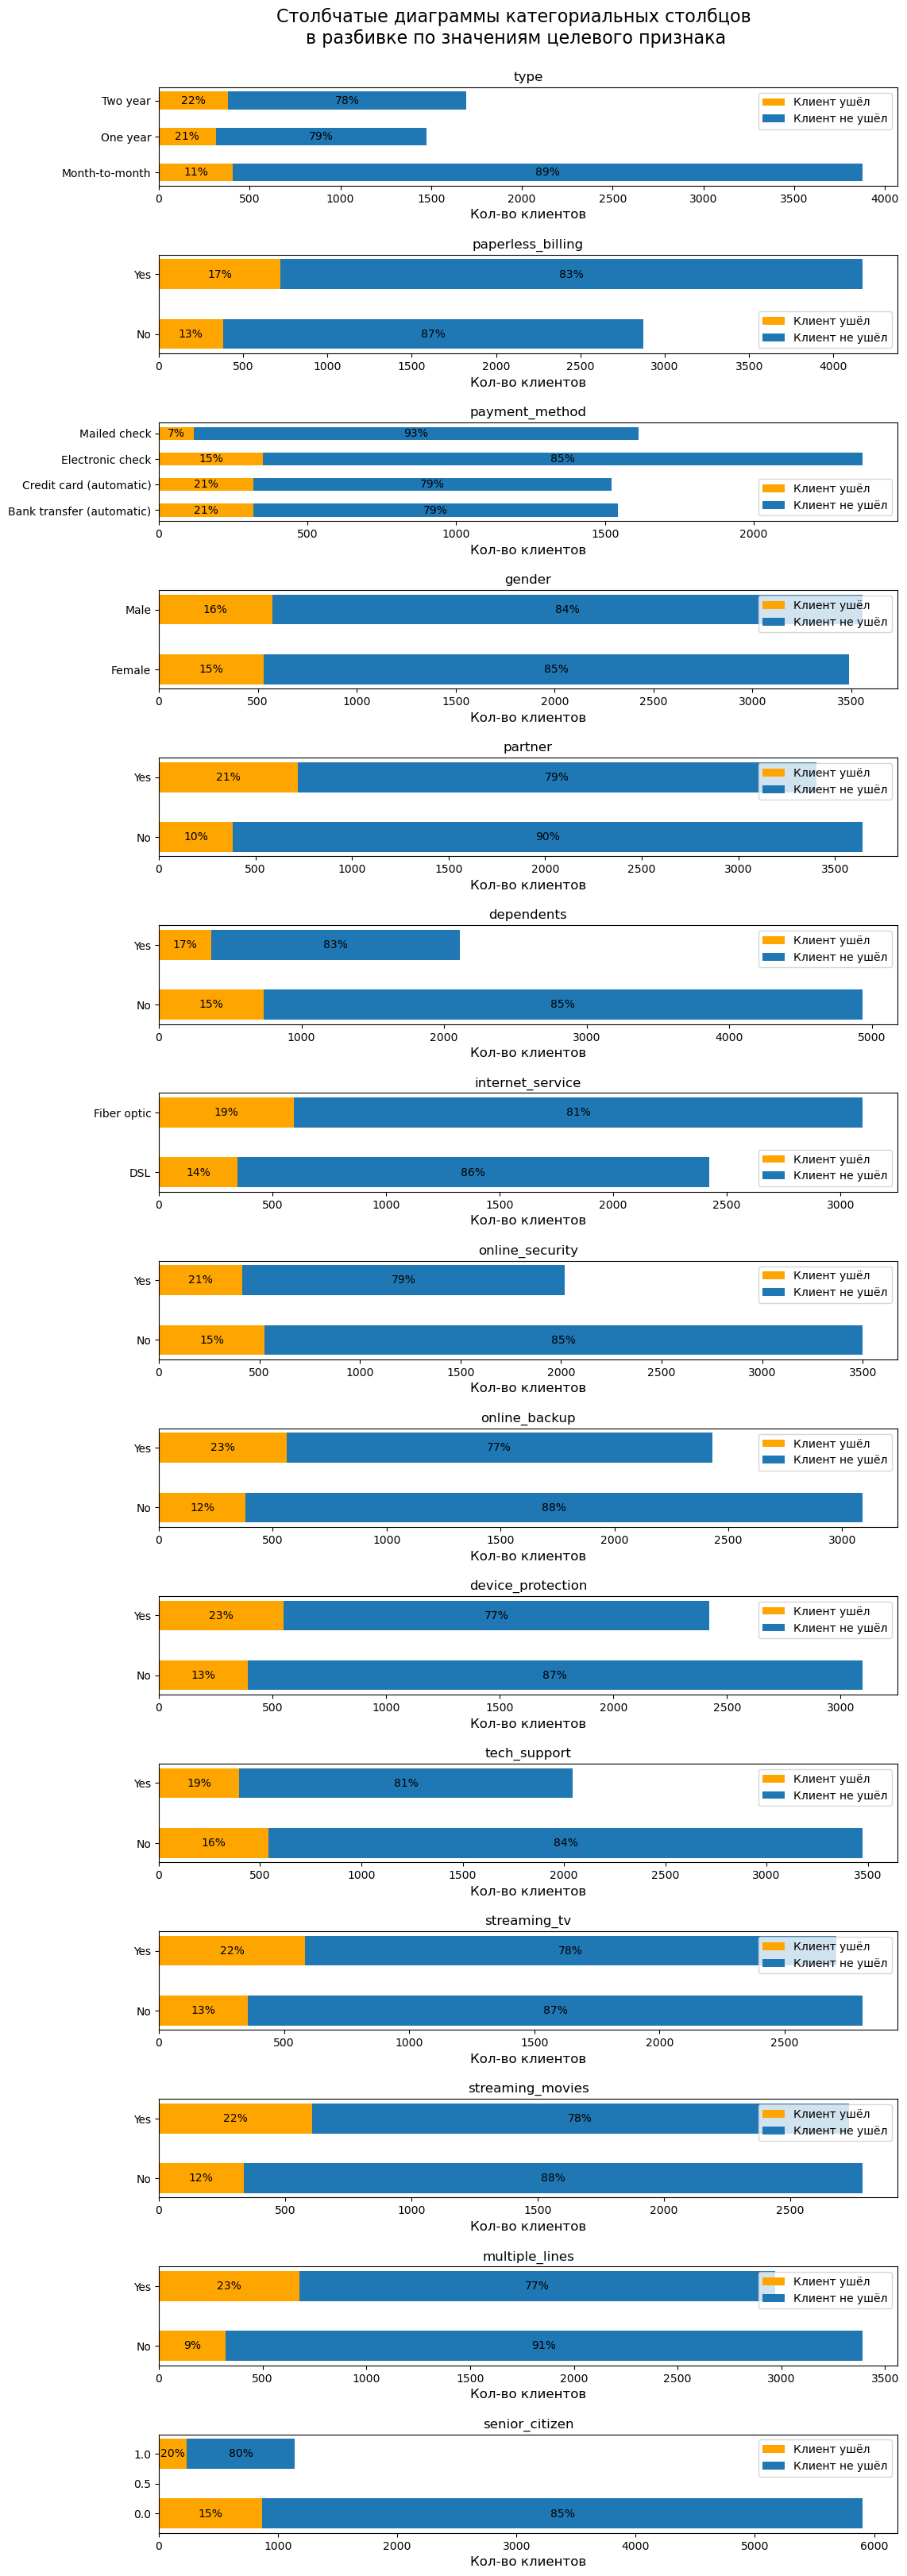

In [27]:
fig = plt.figure(figsize=(12, 40))
fig.subplots_adjust(hspace=0.7)
barWidth = 0.5

for i in range(len(cat_columns)):
    col = cat_columns[i]

    ax = fig.add_subplot(15, 1, i+1)
    
    temp_table = pd.pivot_table(df, index=col, columns='is_not_client', values='customer_id', aggfunc='count')
    
    rect1 = plt.barh(temp_table.index, temp_table[1], height=barWidth, color='orange', label='Клиент ушёл')
    rect2 = plt.barh(temp_table.index, temp_table[0], left=temp_table[1], height=barWidth, label='Клиент не ушёл')
    
    ax.bar_label(rect1, labels=(temp_table[1] / temp_table.sum(axis=1)).map('{:.0%}'.format), label_type='center')
    ax.bar_label(rect2, labels=(temp_table[0] / temp_table.sum(axis=1)).map('{:.0%}'.format), label_type='center')

    plt.title(col)
    plt.xlabel('Кол-во клиентов', fontsize=12)
    plt.legend()
    
plt.suptitle('Столбчатые диаграммы категориальных столбцов \nв разбивке по значениям целевого признака', y=0.905, fontsize=16);

**Выводы.**
* Всего существует три типа оплаты услуг компании: ежемесячная оплат, оплата услуг на год или два вперёд. Причём более половины клиентов пользуется ежемесячной оплатой, а двумя другими типами оплаты пользуется примерно одинаковое количество клиентов, но оплата на два года вперёд всё же чуть более популярна.
* Примерно у 60% клиентов есть электронный платёжный документ.
* Самым популярным методом оплаты услуг компании является выписывание электронного чека, им пользуется около 30% клиентов. Далее идут методы отправки выписанного чека по почте (mailed check), и автоматическая оплата через банк или с помощью кредитной карты; эти три метода примерно одинаково популярны.
* Мужчины и женщины являются клиентами компании примерно в равных долях.
* Около 15% клиентов компании являются пенсионерами.
* Среди клиентов компании примерно в равном количестве есть как люди состоящие в браке, так и не состоящие в нём.
* Примерно 30% клиентов содержат иждивенцев.
* Примерно 80% клиентов пользуется интернет-услугами компании, из них около 45% используют подключение через оптоволоконный кабель (Fiber optic), а оставшиеся 35% через телефонную линию (DSL).
* Примерно 30% клиентов пользуется услугой "блокировка небезопасных сайтов" (online_security). 
* Около 35% клиентов компании пользуется облачным хранилище файлов для резервного копирования данных (online_backup). 
* Около 20% клиентов пользуется антивирусом компании (device_protection). 
* Примерно 30% клиентов пользуется услугой "выделенная линия технической поддержки" (tech_support). 
* Около 20% клиентов компании пользуется стриминговым телевидением (streaming_tv). 
* Примерно 40% клиентов пользуется услугой доступа к каталогу фильмов (streaming_movies). 
* Около 42% клиентов пользуется услугой подключения телефонного аппарата к нескольким линиям одновременно (multiple_lines). 
* Вероятнее всего, что клиенты с пропусками в столбцах с информацией об услугах просто этими услугами не пользуются.  
* Более склонны к уходу те клиенты, которые:
  - используют оплату услуг на год или два вперёд;
  - имеют электронный платёжный документ;
  - пользуются безналичной оплатой (автоматическая оплата через банк или с помощью кредитной карты);
  - состоят в браке;
  - имеют иждивенцев;
  - используют подключение к интернету через оптоволоконный кабель (Fiber optic);
  - используют дополнительные услуги;
  - пользуются услугой подключения телефонного аппарата к нескольким линиям одновременно;
  - имеют пенсионного статус по возрасту.
* Уход клиента практически не зависит от его пола.

Теперь заполним пропуски во всех столбцах. 

Как уже было сказано ранее, пропуски в столбцах с данными об услугах, скорее всего, означают, что конкретный клиент этими услугами просто не пользуется, соответственно заполнять пропуски в таких столбцах будем следующим образом. В столбцах `multiple_lines` и `internet_service` пропуски заполним значениями "no_used", что будет означать, что клиент не пользуется интернет- или телефонными услугами компании. А пропуски во всех остальных столбцах, которые содержат информацию об использовании дополнительных интернет-услуг, заполним значениями "No", поскольку, если у клиента не подключён интернет, то и дополнительными интернет-услугами этой компании он пользоваться не может.

В столбце `total_charges` пропуски заполняем нулями, так как они соответствуют людям, которые только стали клиентами компании и ещё не успели совершить каких-либо оплат.

In [28]:
df['total_charges'] = df['total_charges'].fillna(0.)

df[['internet_service', 'multiple_lines']] = df[['internet_service', 'multiple_lines']].fillna('no_used')

col_services = ['online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df[col_services] = df[col_services].fillna('No')

Проверим, что пропусков в датафрейме не осталось.

In [29]:
print('Количество пропусков:', df.isna().sum().sum())

Количество пропусков: 0


Теперь построим матрицу корреляции признаков между собой, чтобы определить, присутствует ли в них мультиколлинеарность.

In [30]:
corr_matrix = df.drop('customer_id', axis=1).phik_matrix(interval_cols=['monthly_charges', 'total_charges', 
                                                                        'duration_contract'])

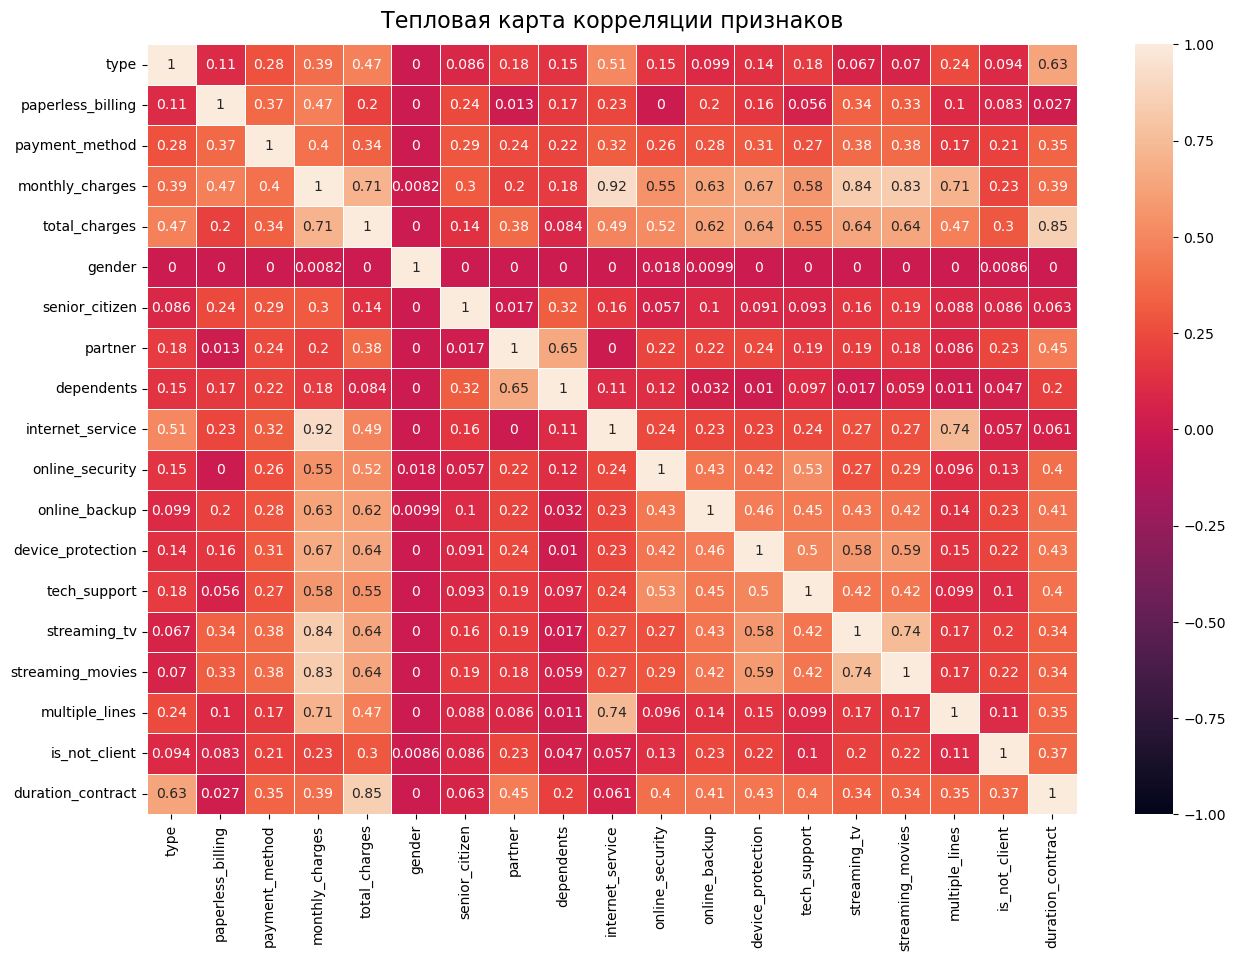

In [31]:
_, ax = plt.subplots(figsize=(15, 10))  
hm = sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, linewidths=0.5, ax=ax);
hm.set_title('Тепловая карта корреляции признаков', fontdict={'fontsize':12}, pad=12, fontsize=16);

Для начала заметим, что целевой признак `is_not_client` не коррелирует ни с одним другим признаком, а это значит, что линейные модели будут показывать не очень хорошие результаты предсказаний.

Будем считать, что признаки мультиколлинеарны, если коэффициент корреляции между ними более 0.8.

Мультиколлинеарность наблюдается между следующими парами признаков:
* `internet_service` и `monthly_charges`;
* `streaming_tv` и `monthly_charges`;
* `streaming_movies` и `monthly_charges`;
* `duration_contract` и `total_charges`.

Однако мы не будем удалять никакие из указанных признаков, поскольку мультиколлинеарность может отрицательно сказаться на линейных моделях, а вот на "деревянные" и бустинговые модели она не оказывает воздействия. Кроме того, наличие мультиколлинеарности далеко не всегда мешает работе даже линейных моделей, а в нашем случае такие модели и так, вероятно, не подойдут для решения поставленной задачи, поскольку целевой признак не имеет сильной линейной зависимости с какими-либо другими признаками.

Далее проверим данные на дисбаланс классов.

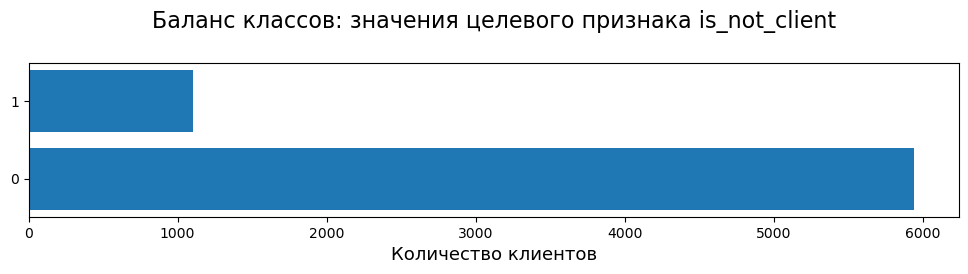

In [32]:
data = df['is_not_client'].value_counts()
fig = plt.figure(figsize=(12, 2))
plt.barh(data.keys().astype(str), width=data.values)
plt.title('Баланс классов: значения целевого признака is_not_client\n', fontsize=16)
plt.xlabel('Количество клиентов', fontsize=13);

Основная используемая метрика в этом проекте *ROC-AUC* нечувствительна к дисбалансу классов, так как зависит от предсказанных вероятностей классов, а не от предсказаний самих классов, как, например, *accuracy*. Именно поэтому *accuracy* не подходит в качестве основной метрики в этом проекте.

## 4. Обучение моделей

### 4.1. Подготовка к обучению моделей

Как уже говорилось ранее, для выбора лучше модели мы будем использовать кросс-валидацию, поэтому данные необходимо разделить только на две выборки: обучающую и тестовую, причём делить мы их будем в соотношении 3:1 соответственно. В признаки для обучения моделей не будем включать признак `customer_id`, так как, поскольку в нём записаны уникальные идентификаторы каждого пользователя, он не несёт никакой полезной информации для обучения моделей.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_not_client', 'customer_id'], axis=1), df['is_not_client'], 
                                                    test_size=0.25, random_state=RANDOM_STATE)

Теперь посмотрим, чему у нас будут равны метрики *ROC-AUC* и *accuracy* константной модели, которая предсказывает, что все значения целевого признака равны наибольшему классу, то есть нулю (клиент не ушёл).

In [34]:
dummy_model = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict_proba(X_test)
roc_auc_dummy = roc_auc_score(y_test, dummy_predictions[:, 1])
accuracy_dummy = dummy_model.score(X_test, y_test)

print('ROC-AUC =', roc_auc_dummy, '\naccuracy =', round(accuracy_dummy, 4))

ROC-AUC = 0.5 
accuracy = 0.837


Таким образом, если далее какая-то модель показывает значения метрик меньше, чем *ROC-AUC* = 0.5 и *accuracy* = 0.837, которые показала константная модель, то такая модель не подходит для решения задачи, поскольку не проходит проверку на адекватность.

Для избежания утечки данных во время кросс-валидации будем использовать пайплайн, а для преобразования данных будем ему передавать объект `ColumnTransformer`. 

Ранее мы уже составляли список `cat_columns` с названиями категориальных признаков и список `num_columns` с названиями числовых. Их же мы и используем для того, чтобы указать, какие категориальные столбцы нужно закодировать, а какие числовые - масштабировать;  эти преобразования будем осуществлять с помощью `OneHotEncoder` и `MinMaxScaler` из библиотеки `sklearn` соответственно.

In [35]:
cat_preprocessing = make_pipeline(
    OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist')
)

num_preprocessing = make_pipeline(MinMaxScaler())

preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_columns), ("cat", cat_preprocessing, cat_columns)]
)

def get_pipeline(model):
    pipeline = Pipeline([
        ("preprocess", preprocessing),
        ('classifier', model)
    ])
    
    return pipeline

И создадим функцию `train_model`, которая будет возвращать обученный объект `RandomizedSearchCV`; с её помощью мы будем подбирать гиперпараметры для каждой модели.

In [36]:
def train_model(model, X_train, y_train, parameter_grid, scoring='roc_auc', cv=5, n_iter=5, refit=False):
    grid=RandomizedSearchCV(
        estimator=get_pipeline(model),
        param_distributions=parameter_grid,
        scoring=scoring,
        cv=cv,
        n_iter=n_iter,
        n_jobs=-1,
        verbose=3,
        refit=refit,
        random_state=RANDOM_STATE
    )
    
    grid.fit(X_train, y_train)
    return grid

### 4.2. Обучение моделей

Теперь перейдём непосредственно к обучению моделей. Обучим модели логистической регрессии, решающего дерева, случайного леса и градиентного бустинга из библиотек `CatBoost` и `LightGBM`.

In [37]:
%%time
#МОДЕЛЬ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

model = LogisticRegression()
grid_lr = train_model(model, X_train, y_train, parameter_grid={}, n_iter=1, refit=True)
print(f'ROC-AUC = {round(grid_lr.best_score_, 4)}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
ROC-AUC = 0.7682
Wall time: 310 ms


In [38]:
%%time
# МОДЕЛЬ РЕШАЮЩЕГО ДЕРЕВА

parameters = {
    'classifier__max_depth': range(50, 2051, 100),
    'classifier__min_samples_split': range(2, 11, 2),
    'classifier__min_samples_leaf': range(1, 10, 2)
}

model = DecisionTreeClassifier(random_state=RANDOM_STATE) 
grid_dt = train_model(model, X_train, y_train, parameter_grid=parameters, n_iter=200)
print(f'ROC-AUC = {round(grid_dt.best_score_, 4)}. Гиперпараметры модели:\n{grid_dt.best_params_}')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
ROC-AUC = 0.7248. Гиперпараметры модели:
{'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 9, 'classifier__max_depth': 650}
Wall time: 7.75 s


In [39]:
%%time
# МОДЕЛЬ СЛУЧАЙНОГО ЛЕС

parameters = {
    'classifier__n_estimators': range(200, 1001, 100),
    'classifier__max_depth': range(50, 2000, 200),
    'classifier__min_samples_split': range(2, 11, 2),
    'classifier__min_samples_leaf': range(1, 10, 2)
}

model = RandomForestClassifier(random_state=RANDOM_STATE) 
grid_rf = train_model(model, X_train, y_train, parameter_grid=parameters, n_iter=20)
print(f'ROC-AUC = {round(grid_rf.best_score_, 4)}. Гиперпараметры модели:\n{grid_rf.best_params_}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
ROC-AUC = 0.823. Гиперпараметры модели:
{'classifier__n_estimators': 800, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 7, 'classifier__max_depth': 250}
Wall time: 33.6 s


In [40]:
%%time
# МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА CatBoost

parameters = {
    'classifier__learning_rate': list(np.arange(0.1, 1, 0.2)) + [0.01, 1],
    'classifier__depth': range(2, 11),
    'classifier__n_estimators': range(100, 1001, 100),
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)
grid_cb = train_model(model, X_train, y_train, parameter_grid=parameters, n_iter=50, refit=True)
print(f'ROC-AUC = {round(grid_cb.best_score_, 4)}. Гиперпараметры модели:\n{grid_cb.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
ROC-AUC = 0.9148. Гиперпараметры модели:
{'classifier__n_estimators': 400, 'classifier__learning_rate': 0.30000000000000004, 'classifier__depth': 3}
Wall time: 3min 4s


In [41]:
%%time
# МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА LightGBM

parameters = {
    'classifier__learning_rate': list(np.arange(0.1, 1, 0.1)) + [0.001, 0.01, 1],
    'classifier__max_depth': range(2, 11),
    'classifier__n_estimators': range(100, 1501, 100),
    'classifier__num_leaves': range(10, 51, 5)  
}

model = LGBMClassifier(random_state=RANDOM_STATE)
grid_lgbm = train_model(model, X_train, y_train, parameter_grid=parameters, n_iter=150)
print(f'ROC-AUC = {round(grid_lgbm.best_score_, 4)}. Гиперпараметры модели:\n{grid_lgbm.best_params_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
ROC-AUC = 0.9001. Гиперпараметры модели:
{'classifier__num_leaves': 45, 'classifier__n_estimators': 1500, 'classifier__max_depth': 2, 'classifier__learning_rate': 0.1}
Wall time: 58.8 s


По результатам кросс-валидации наилучшее значение метрики *ROC-AUC* показала модель градиентного бустинга из библиотеки CatBoost с гиперпараметрами `n_estimators=400`, `learning_rate=0.3`, `depth=3`; *ROC-AUC* этой модели равно 0.9148.

### 4.3. Тестирование выбранной модели. Анализ результатов предсказаний и важности признаков при её обучении

Теперь протестируем ранее выбранную модель CatBoostClassifier и сравним значения метрик *ROC-AUC* и *accuracy*, полученных этой и константной моделями.

In [42]:
model_cb = grid_cb.best_estimator_
cb_predictions = model_cb.predict_proba(X_test)
roc_auc_cb = roc_auc_score(y_test, cb_predictions[:, 1])
accuracy_cb = model_cb.score(X_test, y_test)

print('CatBoostClassifier')
print('ROC-AUC =', round(roc_auc_cb, 4), '\naccuracy =', round(accuracy_cb, 4))

CatBoostClassifier
ROC-AUC = 0.942 
accuracy = 0.9341


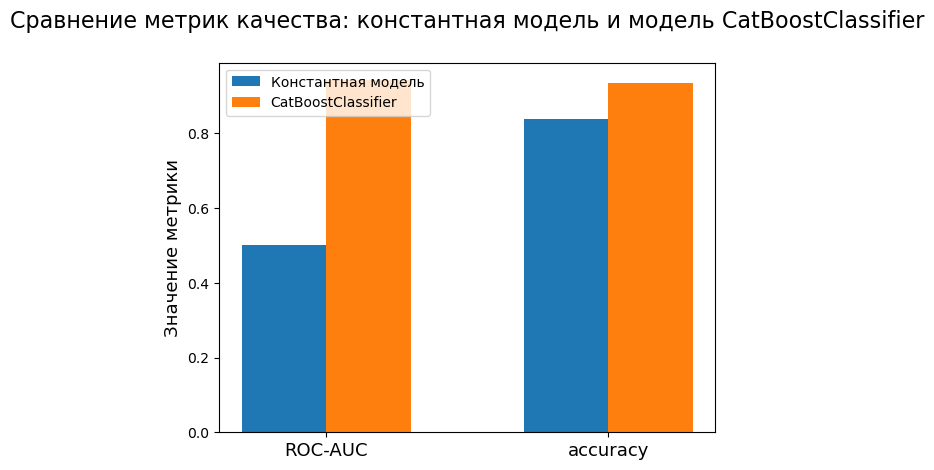

In [43]:
width = 0.3
x = np.arange(0, 2)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [roc_auc_dummy, accuracy_dummy], width, label='Константная модель')
rects2 = ax.bar(x + width/2, [roc_auc_cb, accuracy_cb], width, label='CatBoostClassifier')

ax.set_title('Сравнение метрик качества: константная модель и модель CatBoostClassifier\n', fontsize=16)
ax.set_ylabel('Значение метрики', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(['ROC-AUC', 'accuracy'], fontsize=13)
ax.legend(loc='upper left');

По диаграмме видно, что значение метрики *ROC-AUC* модели CatBoostClassifier на примерно 88% больше, чем было у константной модели, а вот значение метрики *accuracy* изменилось не сильно: оно выросло всего примерно на 12%. Чтобы понять почему так, посмотрим матрицы ошибок и графики *ROC*-кривых выбранной нами модели и константной модели.

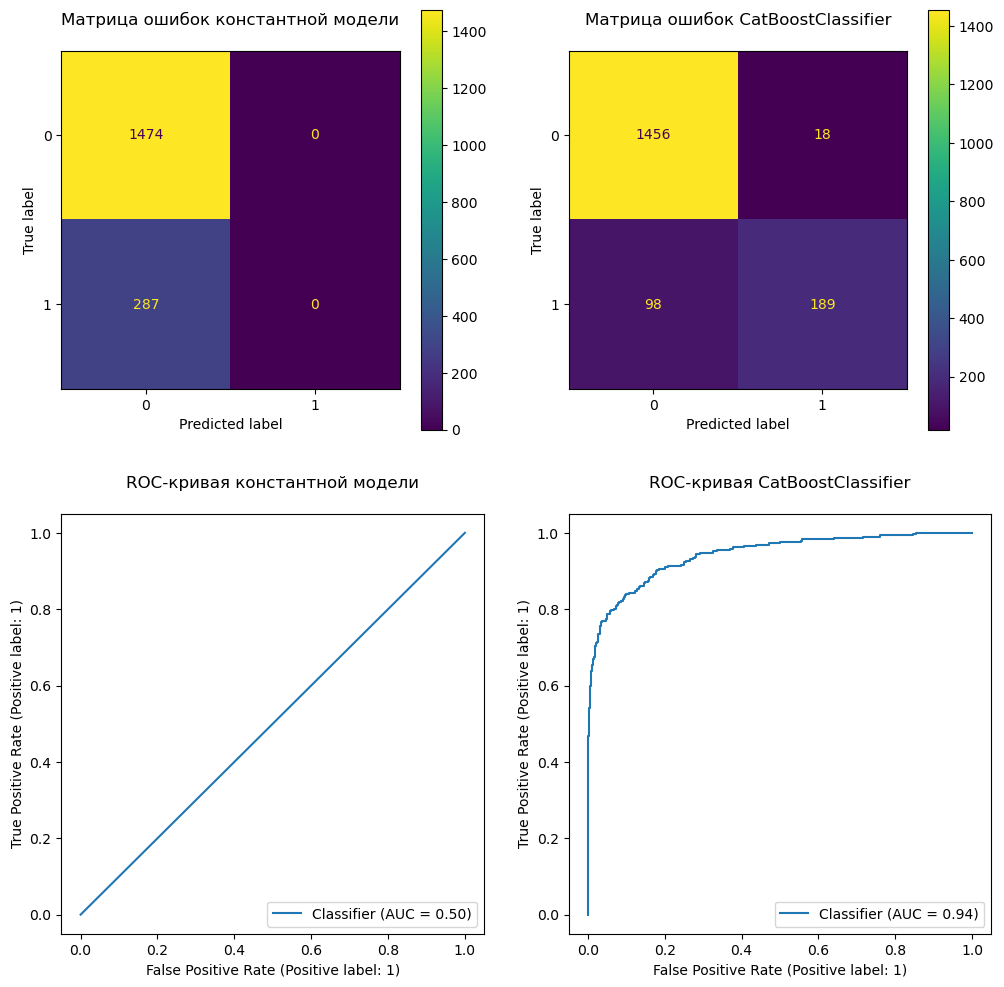

In [44]:
fig = plt.figure(figsize=(12, 12))
ax = fig.subplots(2, 2)

ConfusionMatrixDisplay.from_estimator(dummy_model, X_test, y_test, ax=ax[0, 0])
ax[0, 0].set_title('Матрица ошибок константной модели\n');

ConfusionMatrixDisplay.from_estimator(model_cb, X_test, y_test, ax=ax[0, 1])
ax[0, 1].set_title('Матрица ошибок CatBoostClassifier\n');

RocCurveDisplay.from_predictions(y_test, dummy_predictions[:, 1], ax=ax[1, 0])
ax[1, 0].set_title('ROC-кривая константной модели\n');

RocCurveDisplay.from_predictions(y_test, cb_predictions[:, 1], ax=ax[1, 1])
ax[1, 1].set_title('ROC-кривая CatBoostClassifier\n');

По диаграммам видно, что по сравнению с константной моделью модель CatBoostClassifier значительно лучше отличает объекты одного класса от другого (отражает метрика *ROC-AUC*), однако, при этом количество верных предсказаний увеличилось не сильно (отражает метрика *accuracy*).

Ели посмотреть на матрицы ошибок, то становится видно, что модель CatBoostClassifier позволяет точнее предсказывать уйдёт клиент или нет: в 66% случаях она делает это верно, а в остальных 34% - ошибается, однако, это уже значительно лучше, чем предсказания константной модели, которая вообще не предсказывала уход клиентов. По матрице ошибок также видно, что CatBoostClassifier по сравнению с константной моделью немного хуже предсказывает класс "0", однако, для бизнеса это не столь существенно, поскольку, если клиент не планировал уйти, а ему были предложены какие-то бонусы, то это, скорее всего, только повысит его лояльность к компании. Для бизнеса самым важным является именно предсказания ухода клиента, ведь в этом случае компания сможет повлиять на этот факт, например, предложив ему какие-то бонусы и тем самым сохранив клиента. Даже если не всем клиентам, которые планируют уйти, а только предсказанным верно 66% будут предложены какие-то бонусы, и какая-то часть из этих 66% решит не уходить, то прибыль компании начнёт увеличиваться, поскольку она станет меньше терять клиентов.

Графики *ROC*-кривых моделей только подтверждают всё вышесказанное. Константная модель не могла различать классы, а вот модель CatBoostClassifier делает это достаточно хорошо: её график приближен к идеальному, который проходит через точки (0,0), (0,1), (1,1) и соответствует случаю, когда модель всегда правильно определяет класс объектов.  

Теперь построим график, который отражает важность всех признаков для предсказаний выбранной модели CatBoostClassifier.

In [45]:
model_cb = CatBoostClassifier(n_estimators=400, learning_rate=0.3, depth=3, random_state=RANDOM_STATE, verbose=False)
X_train_preprocess = preprocessing.fit_transform(X_train)
model_cb.fit(X_train_preprocess, y_train)

df_feature_importance = pd.DataFrame({'feature_importance': model_cb.get_feature_importance()},
                                     index=preprocessing.get_feature_names_out()).sort_values(by='feature_importance')

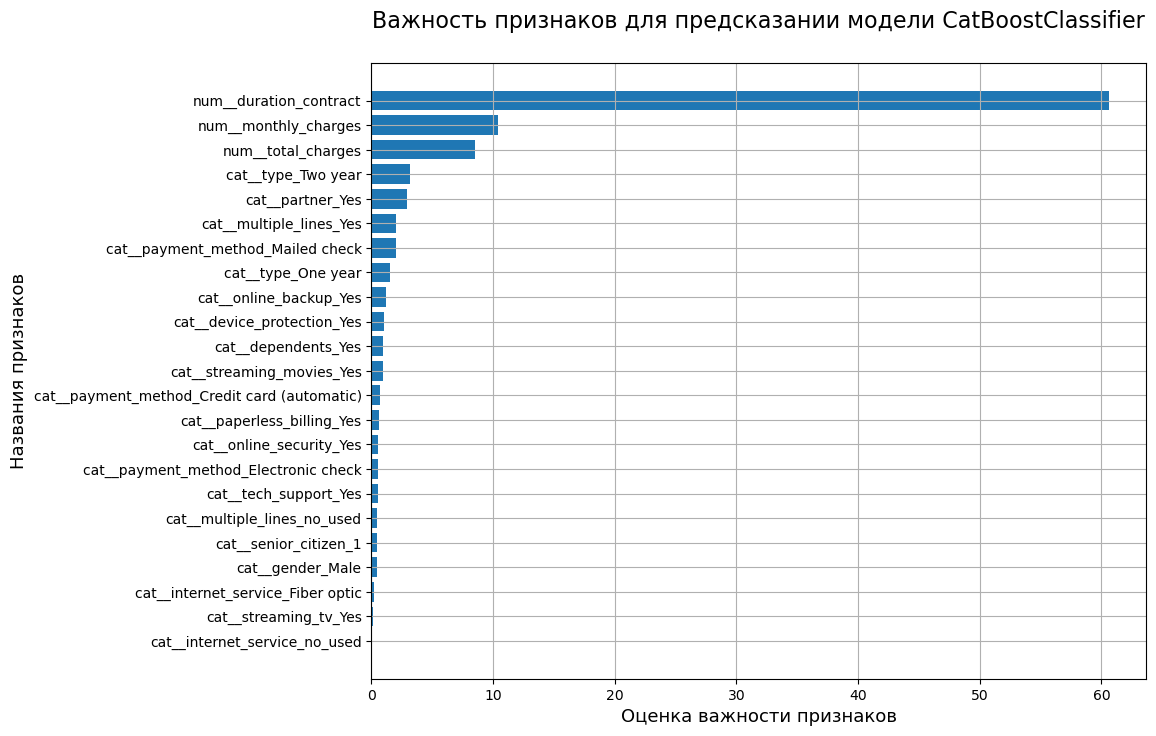

In [46]:
fig = plt.figure(figsize=(10, 8))
plt.barh(df_feature_importance.index, df_feature_importance['feature_importance'])
plt.grid()
plt.title('Важность признаков для предсказании модели CatBoostClassifier\n', fontsize=16)
plt.ylabel('Названия признаков', fontsize=13)
plt.xlabel('Оценка важности признаков', fontsize=13);

Таким образом, получили, что наибольшее влияние на предсказания выбранной модели CatBoostClassifier оказывают численные признаки, и среди них по значимости сильно выделяется признак `duration_contract`: он примерно в 6 сильнее влияет на результат предсказания, чем следующий по значимости признак `monthly_charges`. После численных признаков идут все категориальные; среди них наибольшее влияние на предсказания оказывают признаки `type` и `partner`.

## 5. Выводы

Все поставленные в начале задачи были выполнены. Однако в процессе выполнения проекта я столкнулась с проблемой: при удалении числовых признаков `monthly_charges` и `total_charges`, которые входили в пары мультиколлинеарных признаков, качество всех моделей, в том числе моделей градиентного бустинга, было значительно ниже необходимого порога (*ROC-AUC* < 0.85). Избавиться от этой проблемы помогло то, что я решила не избавляться от мультиколлинеарности в признаках, то есть не удалять признаки `monthly_charges` и `total_charges`, которые, как в дальнейшем выяснилось, являются вторым и третьим признаками по важности. Так можно было сделать, поскольку мультиколлинеарность отрицательно сказывается на линейных моделях и то не всегда, а на модели градиентного бустинга и "деревянные" она влияния не оказывает.

При выполнении проекта я выделила следующие ключевые шаги.
1. Правильно объединить исходные таблицы с данными о персональных данных клиентов и используемых ими услугах.
2. Правильно заполнить пропуски в данных, которые появились после объединения таблиц.
3. Анализ признаков на мультиколлинерарности и принятие решения о том, что никакие признаки, кроме `end_date` и `begin_date`, из которых мы вывели признак `duration_contract` и целевой признак `is_not_client`, удалять не нужно.
4. Подготовка признаков перед обучением моделей: масштабирование численных признаков и кодирование категориальных.
5. Обучение моделей и выбор лучшей.
6. Тестирование выбранной модели и анализ результатов.

Для обучения моделей были использованы следующие признаки.
- type - тип оплаты услуг компании: ежемесячная оплат, оплата услуг на год или два вперёд.          
- paperless_billing - наличие электронного платёжного документа у клиента.
- payment_method - способ оплаты услуг компании.    
- monthly_charges - ежемесячные траты на услуги компании.   
- total_charges - сумма всех потраченных денег на услуги.      
- gender - пол клиента.           
- senior_citizen - наличие пенсионного статусу по возрасту.      
- partner - состоит ли клиент в браке.            
- dependents - наличие иждивенцев.         
- internet_service - пользуется ли клиент интернет-услугами компании, и если пользуется, то какой тип подключения использует.   
- online_security - пользуется ли клиент услугой "блокировка небезопасных сайтов".    
- online_backup - пользуется ли клиент облачным хранилище файлов для резервного копирования данных.   
- device_protection - пользуется ли клиент антивирусом компании.
- tech_support - пользуется ли клиент услугой "выделенная линия технической поддержки".       
- streaming_tv - пользуется ли клиент стриминговым телевидением компании.        
- streaming_movies - пользуется ли клиент услугой доступа к каталогу фильмов.  
- multiple_lines - наличие возможности ведения параллельных линий во время звонков.     
- duration_contract - длительность контракта клиента с компанией.

Была выполнена следующая предобработка указанных выше признаков.
- Пробелы в столбце `total_charges` были заполнены нулями, что означает, что клиент новый и ещё не успел совершить ни одной оплаты.
- Пропуски в столбцах с данными об услугах были заполнены следующим образом. В столбцах `multiple_lines` и `internet_service` пропуски заполнили значениями "no_used", что будет означать, что клиент не пользуется интернет- или телефонными услугами компании. А пропуски во всех остальных столбцах, которые содержат информацию об использовании дополнительных интернет-услуг, заполним значениями "No", поскольку, если у клиента не подключён интернет, то и дополнительными интернет-услугами этой компании он пользоваться не может.
- Перед обучением моделей все числовые признаки масштабируются методом `MinMaxScaler`, а категориальные кодируются с использованием `OneHotEncoder` библиотеки `sklearn`, причём осуществляется это с помощью пайплайнов.

Лучший результат на этапе кросс-валидации показала модель градиентного бустинга `CatBoostClassifier` с гиперпараметрами `n_estimators=400`, `learning_rate=0.3`, `depth=3`, `random_state=170723`. *ROC-AUC* этой модели тестовой выборке равен 0.942, а *accuracy* - 0.9341.